In [9]:
import os
import re
import unicodedata
import gc
import json
import random
import joblib

from joblib import Parallel, delayed
from collections import Counter

import modin.pandas as pd
import swifter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tqdm.auto import tqdm

# ==================== Configuration ====================
EMBEDDING_DIM     = 100
HIDDEN_DIM        = 128
NUM_HEADS         = 4
NUM_FILTERS       = 100
KERNEL_SIZES      = [2]
DROPOUT           = 0.2
LR                = 1e-4
BATCH_SIZE        = 32
NUM_EPOCHS        = 30
MAX_LEN           = 256
PAD_TOKEN         = "<pad>"
UNK_TOKEN         = "<unk>"
TEST_SPLIT_RATIO  = 0.2
FREEZE_EMBEDDINGS = False
PATIENCE          = 5

BEST_MODEL_FILENAME = 'best_email_classifier.pt'
ARTIFACTS_DIR       = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

W2V_WINDOW    = 15
W2V_MIN_COUNT = 10
W2V_WORKERS   = os.cpu_count()
W2V_RUNS      = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== NLTK Setup ====================
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# ==================== Text Normalization ====================
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize('NFKC', text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')).union({
    'subject','re','fw','fwd','sent','from','to','cc','bcc',
    'http','https','www','com','org','net','am','pm',
    'dear','hello','hi','thanks','best','regards',
    'please','mail','email','message','list','address','nbsp'
})

# ==================== Data Preprocessing ====================
def preprocess_data(filepath, max_len):
    print("Start preprocessing data...")
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['text_combined']).reset_index(drop=True)
    df['normalized_text'] = df['text_combined'].swifter.apply(normalize_text)

    # Build vectorizers and update stopwords
    cv = CountVectorizer(token_pattern=r"\b[a-z]{2,}\b")
    counts = cv.fit_transform(df['normalized_text'])
    freqs = dict(zip(cv.get_feature_names_out(), counts.sum(axis=0).A1))
    most = sorted(freqs.items(), key=lambda x: -x[1])[:50]
    least = sorted(freqs.items(), key=lambda x: x[1])[:50]
    stop_words.update(w for w,_ in most)
    stop_words.update(w for w,_ in least)

    tv = TfidfVectorizer(token_pattern=r"\b[a-z]{2,}\b", use_idf=True)
    tv.fit(df['normalized_text'])
    idf = dict(zip(tv.get_feature_names_out(), tv.idf_))
    low_idf = sorted(idf.items(), key=lambda x: x[1])[:50]
    stop_words.update(w for w,_ in low_idf)

    gc.collect()

    # Parallel tokenization and lemmatization
    print("Tokenizing in parallel...")
    def tokenize_and_lemmatize(text):
        toks = word_tokenize(text)
        return [lemmatizer.lemmatize(t) for t in toks if t not in stop_words]
    print(df['normalized_text'])
    texts = df['normalized_text'].tolist()
    sentences = Parallel(n_jobs=W2V_WORKERS, backend="threading")(  
        delayed(tokenize_and_lemmatize)(text) for text in tqdm(texts, desc="Tokenizing texts", total=len(texts))
    )
    toks_for_w2v = sentences
    raw_labels = df['label'].astype(str).str.strip().tolist()
    print("Preprocessing completed.")

    # Build vocab and label mappings
    all_words = Counter([w for sent in toks_for_w2v for w in sent])
    vocab = {w: i+2 for i, w in enumerate(all_words.keys())}
    vocab[PAD_TOKEN] = 0
    vocab[UNK_TOKEN] = 1
    unique_labels = sorted(set(raw_labels))
    label_map    = {lbl: i for i, lbl in enumerate(unique_labels)}
    idx_to_label = {i: lbl for lbl, i in label_map.items()}

    # Convert texts to sequences
    X, Y = [], []
    for toks, lbl in zip(sentences, raw_labels):
        nums = [vocab.get(t, vocab[UNK_TOKEN]) for t in toks]
        if len(nums) < max_len:
            nums += [vocab[PAD_TOKEN]] * (max_len - len(nums))
        else:
            nums = nums[:max_len]
        X.append(nums)
        Y.append(label_map[lbl])
    return X, Y, toks_for_w2v, vocab, label_map, idx_to_label, cv, tv

# ==================== Word2Vec Training ====================
def train_word2vec_avg(tokenized_sentences, embedding_dim, window, min_count, workers, runs=1):
    print("\nStart Word2Vec training...")
    sum_vec, keys = None, None
    for _ in tqdm(range(runs), desc="Word2Vec runs"):
        m = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=embedding_dim,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=1
        )
        vecs = m.wv.vectors
        if sum_vec is None:
            sum_vec = vecs.astype(float)
            keys = m.wv.index_to_key
        else:
            sum_vec += vecs
    avg_vec = sum_vec / runs
    kv = KeyedVectors(vector_size=embedding_dim)
    kv.add_vectors(keys, avg_vec)
    print("Word2Vec training completed.")
    return kv

# ==================== Embedding Matrix ====================
def create_embedding_matrix(kv, vocab, embedding_dim):
    print("Creating embedding matrix...")
    mat = np.zeros((len(vocab), embedding_dim))
    cnt = 0
    for w, idx in vocab.items():
        if w in kv:
            mat[idx] = kv[w]
            cnt += 1
    print(f"Initialized {cnt}/{len(vocab)} tokens.")
    return torch.tensor(mat, dtype=torch.float)

# ==================== Dataset & Model ====================
class SentimentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.Y[idx], dtype=torch.long)

class CNNBiLSTM_MHA(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_sizes,
                 hidden_dim, num_heads, output_dim, dropout, pad_idx,
                 pretrained_matrix=None, freeze_embeddings=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        if pretrained_matrix is not None:
            print("Loading pretrained embeddings...")
            self.embedding.weight.data.copy_(pretrained_matrix)
            self.embedding.weight.requires_grad = not freeze_embeddings
        else:
            print("Training embeddings from scratch.")

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, ks)
            for ks in kernel_sizes
        ])

        # BiLSTM
        self.lstm = nn.LSTM(
            num_filters,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        # Multi-head attention
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.pad_idx = pad_idx

    def forward(self, text):
        # text: [batch_size, seq_len]
        mask = (text == self.pad_idx)  # [batch_size, seq_len]

        # Embedding + dropout
        emb = self.dropout(self.embedding(text))  # [batch, seq_len, emb_dim]

        # Convolution expects [batch, emb_dim, seq_len]
        x = emb.permute(0, 2, 1)
        # apply first conv + ReLU, then permute back
        c = torch.relu(self.convs[0](x)).permute(0, 2, 1)  # [batch, seq_len, num_filters]

        # BiLSTM
        out, _ = self.lstm(self.dropout(c))  # [batch, seq_len, hidden_dim*2]

        # Adjust mask if seq_len changed
        if out.size(1) != mask.size(1):
            diff = out.size(1) - mask.size(1)
            if diff > 0:
                mask = torch.cat([mask, mask.new_ones(mask.size(0), diff)], dim=1)
            else:
                mask = mask[:, :out.size(1)]

        # Multi-head attention
        attn_out, _ = self.attn(out, out, out, key_padding_mask=mask)
        # Zero out padded positions
        attn_out = attn_out.masked_fill(mask.unsqueeze(-1), 0.0)

        # Sum pooling
        summed = attn_out.sum(1)  # [batch, hidden_dim*2]
        cnt_nonpad = (~mask).sum(1).clamp(min=1).unsqueeze(1)
        pooled = summed / cnt_nonpad  # [batch, hidden_dim*2]

        # Classifier
        logits = self.fc(self.dropout(pooled))  # [batch, output_dim]
        probs = self.softmax(logits)
        return probs, logits

# ==================== Training & Evaluation ====================

def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for Xb, yb in tqdm(loader, desc="Training batches"):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()

        probs, logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = probs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.cpu().numpy())

    avg_loss = total_loss / len(loader)
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return avg_loss, acc, f1


def evaluate_model(model, loader, criterion, idx_to_label, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for Xb, yb in tqdm(loader, desc="Evaluation batches"):
        with torch.no_grad():
            Xb, yb = Xb.to(device), yb.to(device)
            probs, logits = model(Xb)
            total_loss += criterion(logits, yb).item()
            preds = probs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.cpu().numpy())

    avg_loss = total_loss / len(loader)
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("\n--- Classification Report ---")
    print(classification_report(
        y_true,
        y_pred,
        target_names=[idx_to_label[i] for i in range(len(idx_to_label))],
        zero_division=0,
        digits=4
    ))

    return avg_loss, acc, f1

# ==================== Data Artifacts Saving & Loading ====================
def save_data_artifacts(vocab, label_map, idx_to_label, cv, tv, emb_mat, X, Y, kv, artifacts_dir=ARTIFACTS_DIR):
    os.makedirs(artifacts_dir, exist_ok=True)
    print("Saving data artifacts...")
    joblib.dump(vocab, os.path.join(artifacts_dir, 'vocab.joblib'))
    joblib.dump(label_map, os.path.join(artifacts_dir, 'label_map.joblib'))
    joblib.dump(idx_to_label, os.path.join(artifacts_dir, 'idx_to_label.joblib'))
    joblib.dump(cv, os.path.join(artifacts_dir, 'count_vectorizer.joblib'))
    joblib.dump(tv, os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))
    joblib.dump(emb_mat, os.path.join(artifacts_dir, 'embedding_matrix.joblib'))
    joblib.dump((X, Y), os.path.join(artifacts_dir, 'dataset_XY.joblib'))
    kv.save(os.path.join(artifacts_dir, 'word2vec_avg.kv'))
    print(f"✅ Data artifacts saved to {artifacts_dir}/")


def load_data_artifacts(artifacts_dir=ARTIFACTS_DIR):
    print("Loading data artifacts...")
    vocab        = joblib.load(os.path.join(artifacts_dir, 'vocab.joblib'))
    label_map    = joblib.load(os.path.join(artifacts_dir, 'label_map.joblib'))
    idx_to_label = joblib.load(os.path.join(artifacts_dir, 'idx_to_label.joblib'))
    cv           = joblib.load(os.path.join(artifacts_dir, 'count_vectorizer.joblib'))
    tv           = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))
    emb_mat      = joblib.load(os.path.join(artifacts_dir, 'embedding_matrix.joblib'))
    X, Y         = joblib.load(os.path.join(artifacts_dir, 'dataset_XY.joblib'))
    kv           = KeyedVectors.load(os.path.join(artifacts_dir, 'word2vec_avg.kv'), mmap='r')
    print(f"✅ Data artifacts loaded from {artifacts_dir}/")
    return X, Y, vocab, label_map, idx_to_label, cv, tv, emb_mat, kv

# ==================== Main Execution ====================
if __name__ == "__main__":
    # Attempt to load data artifacts, otherwise generate them
    data_file = os.path.join(ARTIFACTS_DIR, 'dataset_XY.joblib')
    if os.path.exists(data_file):
        X, Y, vocab, label_map, idx_to_label, cv, tv, emb_mat, kv = load_data_artifacts()
    else:
        X, Y, toks, vocab, label_map, idx_to_label, cv, tv = preprocess_data(
            "phishing_email.csv", MAX_LEN
        )
        kv      = train_word2vec_avg(toks, EMBEDDING_DIM, W2V_WINDOW, W2V_MIN_COUNT, W2V_WORKERS, runs=W2V_RUNS)
        emb_mat = create_embedding_matrix(kv, vocab, EMBEDDING_DIM)
        save_data_artifacts(vocab, label_map, idx_to_label, cv, tv, emb_mat, X, Y, kv)

    # Prepare data loaders
    print("Preparing data loaders...")
    dataset   = SentimentDataset(X, Y)
    test_size = int(len(dataset) * TEST_SPLIT_RATIO)
    train_size= len(dataset) - test_size
    train_ds, test_ds = (
        random_split(dataset, [train_size, test_size]) if test_size>0 else (dataset, None)
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE) if test_ds else None

    # Initialize model, optimizer, criterion
    model = CNNBiLSTM_MHA(
        vocab_size=len(vocab), embedding_dim=EMBEDDING_DIM,
        num_filters=NUM_FILTERS, kernel_sizes=KERNEL_SIZES,
        hidden_dim=HIDDEN_DIM, num_heads=NUM_HEADS,
        output_dim=len(label_map), dropout=DROPOUT,
        pad_idx=vocab[PAD_TOKEN], pretrained_matrix=emb_mat,
        freeze_embeddings=FREEZE_EMBEDDINGS
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    # Training loop with early stopping
    best_f1 = 0.0
    epochs_no_improve = 0
    print("Starting training...")
    for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
        tr_loss, tr_acc, tr_f1 = train_model(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} — loss: {tr_loss:.4f} — acc: {tr_acc:.4f} — f1: {tr_f1:.4f}")
        if test_loader:
            val_loss, val_acc, val_f1 = evaluate_model(model, test_loader, criterion, idx_to_label)
            print(f"Validation — loss: {val_loss:.4f} — acc: {val_acc:.4f} — f1: {val_f1:.4f}\n")
            if val_f1 > best_f1:
                best_f1 = val_f1
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}.")
                    break

    # Save trained model state
    torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, BEST_MODEL_FILENAME))
    print(f"✅ Model state saved to {BEST_MODEL_FILENAME}")

    # Optional: test inference on a sample
    sample = "Congratulations! You've won a free ticket. Click here..."
    toks   = sample.lower().split()
    nums   = [vocab.get(t, vocab[UNK_TOKEN]) for t in toks]
    nums   = nums[:MAX_LEN] + [vocab[PAD_TOKEN]]*(MAX_LEN-len(nums))
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor([nums], dtype=torch.long).to(device))
        pred   = logits.argmax(dim=1).item()
    print(f"Sample prediction: {idx_to_label[pred]}")


Using device: cpu
Loading data artifacts...
✅ Data artifacts loaded from artifacts/
Preparing data loaders...
Loading pretrained embeddings...
Starting training...


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training batches:   0%|          | 0/2063 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder


2025-05-06 19:20:38.883586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746534039.037360  227675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746534039.081790  227675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746534039.375794  227675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746534039.375817  227675 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746534039.375820  227675 computation_placer.cc:177] computation placer alr

In [23]:
# Load the dataset
# df = pd.read_csv('phishing_email.csv')
df = pd.read_excel('phishing_email_with_translation_clean_1.xlsx')

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['translation'], df['label'], test_size=0.3, random_state=42)


# TF-IDF Vectorization for traditional models
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

import joblib

# Save the trained TF-IDF vectorizer
os.makedirs('ML_archive_VN', exist_ok=True)

joblib.dump(tfidf, os.path.join('ML_archive_VN', f'{"tfidf_vectorizer"}.joblib'))
joblib.dump(le, os.path.join('ML_archive_VN', f'{"label_encoder"}.joblib'))


/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['ML_archive_VN/label_encoder.joblib']

In [24]:
import os
import time
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    """
    Huấn luyện model, đánh giá, hiển thị kết quả và lưu model ra file .joblib
    """
    # Tạo thư mục lưu model nếu chưa có
    os.makedirs('ML_archive_VN', exist_ok=True)
    
    # 1. Huấn luyện
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    # 2. Dự đoán & in classification report
    preds = model.predict(X_test)
    print(f"\n=== Classification Report: {model_name} ===")
    print(classification_report(y_test, preds, digits=4))
    
    # 3. ROC AUC (nếu hỗ trợ predict_proba)
    try:
        probs = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, probs)
        print(f"ROC AUC: {roc_auc:.4f}")
    except Exception:
        print("ROC AUC: không tính được (model không hỗ trợ predict_proba)")
    
    # 4. Thời gian huấn luyện
    print(f"Training Time: {elapsed_time:.2f} seconds")
    
    # 5. Hiển thị confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # 6. Lưu model ra joblib
    model_path = os.path.join('ML_archive', f'{model_name}.joblib')
    joblib.dump(model, model_path)
    print(f"Model đã được lưu tại: {model_path}\n")
    
    return model



=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9757    0.9658    0.9707     10497
           1     0.9658    0.9758    0.9708     10392

    accuracy                         0.9708     20889
   macro avg     0.9708    0.9708    0.9708     20889
weighted avg     0.9708    0.9708    0.9708     20889

ROC AUC: 0.9956
Training Time: 0.45 seconds


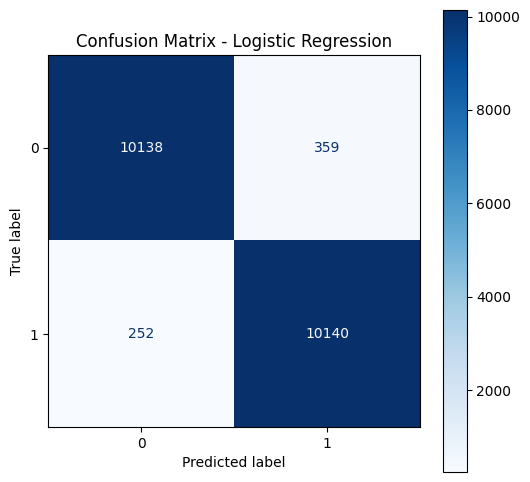

Model đã được lưu tại: ML_archive/Logistic Regression.joblib


=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.9592    0.9784    0.9687     10497
           1     0.9777    0.9579    0.9677     10392

    accuracy                         0.9682     20889
   macro avg     0.9684    0.9682    0.9682     20889
weighted avg     0.9684    0.9682    0.9682     20889

ROC AUC: 0.9952
Training Time: 146.52 seconds


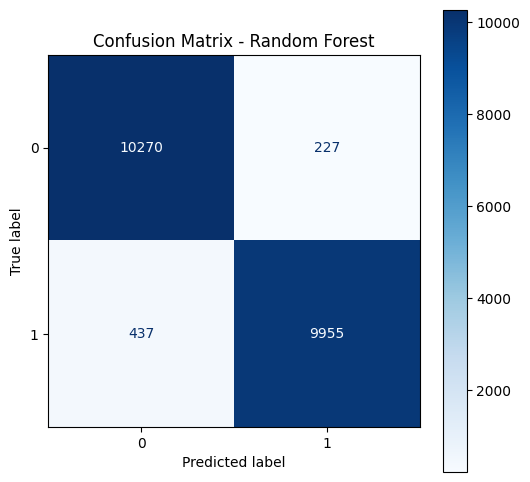

Model đã được lưu tại: ML_archive/Random Forest.joblib



/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:26:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report: XGBoost ===
              precision    recall  f1-score   support

           0     0.9806    0.9689    0.9747     10497
           1     0.9690    0.9807    0.9748     10392

    accuracy                         0.9748     20889
   macro avg     0.9748    0.9748    0.9748     20889
weighted avg     0.9748    0.9748    0.9748     20889

ROC AUC: 0.9970
Training Time: 28.67 seconds


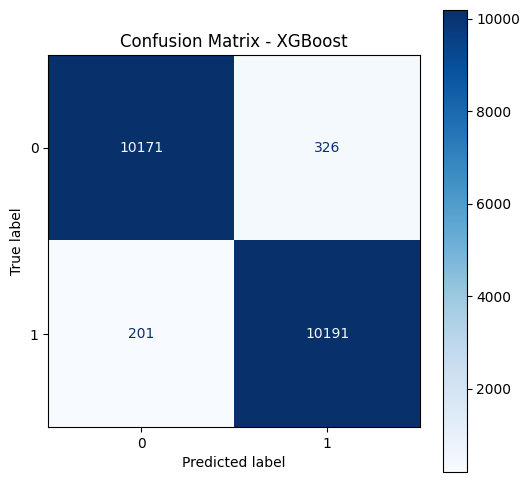

Model đã được lưu tại: ML_archive/XGBoost.joblib


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0     0.9095    0.9698    0.9387     10497
           1     0.9673    0.9025    0.9338     10392

    accuracy                         0.9363     20889
   macro avg     0.9384    0.9362    0.9362     20889
weighted avg     0.9383    0.9363    0.9362     20889

ROC AUC: 0.9898
Training Time: 0.04 seconds


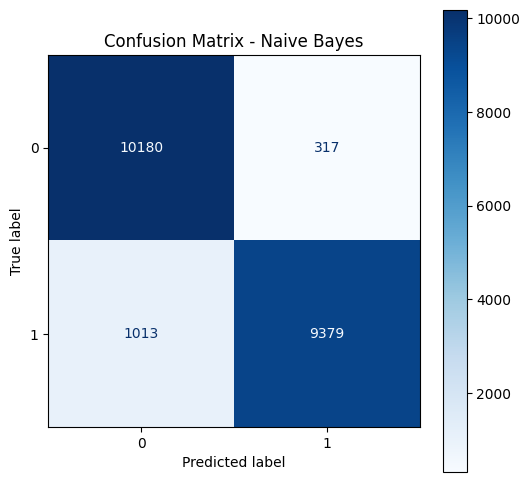

Model đã được lưu tại: ML_archive/Naive Bayes.joblib


=== Classification Report: Extra Trees ===
              precision    recall  f1-score   support

           0     0.9600    0.9837    0.9717     10497
           1     0.9831    0.9586    0.9707     10392

    accuracy                         0.9712     20889
   macro avg     0.9716    0.9712    0.9712     20889
weighted avg     0.9715    0.9712    0.9712     20889

ROC AUC: 0.9963
Training Time: 188.13 seconds


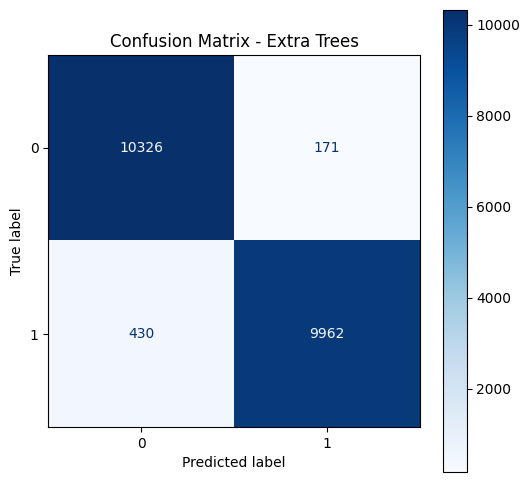

Model đã được lưu tại: ML_archive/Extra Trees.joblib

[LightGBM] [Info] Number of positive: 24152, number of negative: 24586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551892
[LightGBM] [Info] Number of data points in the train set: 48738, number of used features: 4926
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495548 -> initscore=-0.017810
[LightGBM] [Info] Start training from score -0.017810


/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Classification Report: LightGBM ===
              precision    recall  f1-score   support

           0     0.9804    0.9703    0.9753     10497
           1     0.9703    0.9804    0.9753     10392

    accuracy                         0.9753     20889
   macro avg     0.9753    0.9753    0.9753     20889
weighted avg     0.9754    0.9753    0.9753     20889

ROC AUC: 0.9972
Training Time: 13.00 seconds


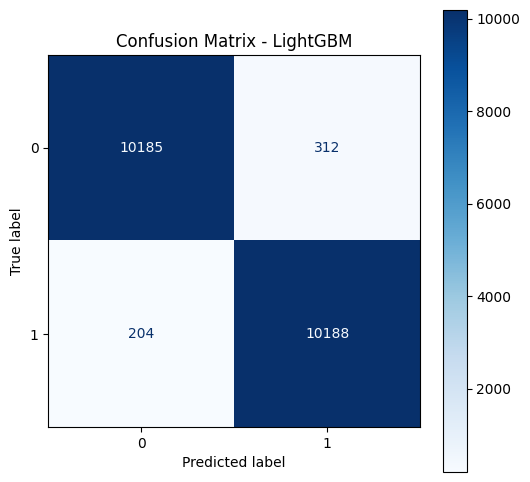

Model đã được lưu tại: ML_archive/LightGBM.joblib

[LightGBM] [Info] Number of positive: 24152, number of negative: 24586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551892
[LightGBM] [Info] Number of data points in the train set: 48738, number of used features: 4926
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495548 -> initscore=-0.017810
[LightGBM] [Info] Start training from score -0.017810


/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Classification Report: Voting Classifier ===
              precision    recall  f1-score   support

           0     0.9780    0.9777    0.9778     10497
           1     0.9775    0.9778    0.9776     10392

    accuracy                         0.9777     20889
   macro avg     0.9777    0.9777    0.9777     20889
weighted avg     0.9777    0.9777    0.9777     20889

ROC AUC: 0.9974
Training Time: 346.19 seconds


/home/duycute/.pyenv/versions/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


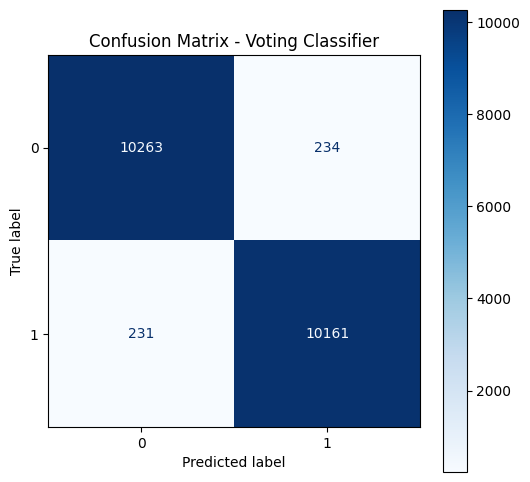

Model đã được lưu tại: ML_archive/Voting Classifier.joblib



In [25]:
logistic_regression_model = train_and_evaluate(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression")
random_forest_model = train_and_evaluate(RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest")
xgboost_model = train_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_train_tfidf, y_train, X_test_tfidf, y_test, "XGBoost")
naive_bayes_model = train_and_evaluate(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test, "Naive Bayes")
extra_trees_model = train_and_evaluate(ExtraTreesClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test, "Extra Trees")
lightgbm_model = train_and_evaluate(LGBMClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test, "LightGBM")

random_forest_model = RandomForestClassifier()
extra_trees_model = ExtraTreesClassifier()
lightgbm_model = LGBMClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_forest_model),
        ('et', extra_trees_model),
        ('lgbm', lightgbm_model)
    ],
    voting='soft'
)
voting_model = train_and_evaluate(voting_clf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Voting Classifier")

In [11]:
# Tokenize text data for deep learning models
max_vocab_size = 10000
max_seq_length = 100
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['text_combined'])
sequences = tokenizer.texts_to_sequences(df['text_combined'])
X = pad_sequences(sequences, maxlen=max_seq_length)

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(df['label'])

# Train-Test Split for deep learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Load pre-trained GloVe embeddings
embedding_dim = 100
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(max_vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Load the dataset
df = pd.read_csv('phishing_email.csv')

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text_combined'], df['label'], test_size=0.3, random_state=42)


# TF-IDF Vectorization for traditional models
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization,
    Bidirectional, LSTM, MultiHeadAttention, LayerNormalization,
    Concatenate, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping

# hyper-parameters (tweak as you like)
conv_filters   = 64
kernel_size    = 3
lstm_units     = 64
attention_heads= 4
dropout_rate   = 0.5

# inputs
input_layer = Input(shape=(max_seq_length,))

# frozen embedding
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_seq_length,
    trainable=False
)(input_layer)

# ┌─ Conv-branch ───────────────────────────────────────────┐
conv = Conv1D(filters=conv_filters,
              kernel_size=kernel_size,
              padding='same',
              activation='relu')(embedding_layer)
conv_pool = GlobalMaxPooling1D()(conv)
conv_bn   = BatchNormalization()(conv_pool)
# └─────────────────────────────────────────────────────────┘

# ┌─ LSTM + Attention branch ────────────────────────────────┐
# 1) Bi-LSTM over the sequence
lstm_seq = Bidirectional(
    LSTM(lstm_units, return_sequences=True)
)(embedding_layer)

# 2) Multi-head self-attention on LSTM outputs
attn = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=lstm_units
)(lstm_seq, lstm_seq)
attn_norm = LayerNormalization()(attn)

# 3) Pool + normalize
attn_pool = GlobalMaxPooling1D()(attn_norm)
attn_bn   = BatchNormalization()(attn_pool)
# └─────────────────────────────────────────────────────────┘

# concatenate conv & attention features
merged = Concatenate()([conv_bn, attn_bn])

# fully-connected head
fc      = Dense(64, activation='relu')(merged)
drop    = Dropout(dropout_rate)(fc)
output  = Dense(1, activation='sigmoid')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# training callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)


In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, callbacks=[early_stopping])

Epoch 1/50
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 212s 57ms/step - accuracy: 0.9123 - loss: 0.2260 - val_accuracy: 0.9751 - val_loss: 0.0688
Epoch 2/50
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 206s 57ms/step - accuracy: 0.9727 - loss: 0.0821 - val_accuracy: 0.9822 - val_loss: 0.0538
Epoch 3/50
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 205s 57ms/step - accuracy: 0.9811 - loss: 0.0562 - val_accuracy: 0.9836 - val_loss: 0.0458
Epoch 4/50
3341/3609 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9875 - loss: 0.0385

KeyboardInterrupt: 

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:

# Attempt to load data artifacts, otherwise generate them
data_file = os.path.join(ARTIFACTS_DIR, 'dataset_XY.joblib')
if os.path.exists(data_file):
    X, Y, vocab, label_map, idx_to_label, cv, tv, emb_mat, kv = load_data_artifacts()
else:
    X, Y, toks, vocab, label_map, idx_to_label, cv, tv = preprocess_data(
        "/kaggle/input/phishing-email-dataset/phishing_email.csv", MAX_LEN
    )
    kv      = train_word2vec_avg(toks, EMBEDDING_DIM, W2V_WINDOW, W2V_MIN_COUNT, runs=2)
    emb_mat = create_embedding_matrix(kv, vocab, EMBEDDING_DIM)
    save_data_artifacts(vocab, label_map, idx_to_label, cv, tv, emb_mat, X, Y, kv)

# Prepare data loaders
print("Preparing data loaders...")
dataset   = SentimentDataset(X, Y)
test_size = int(len(dataset) * TEST_SPLIT_RATIO)
train_size= len(dataset) - test_size
train_ds, test_ds = (
    random_split(dataset, [train_size, test_size]) if test_size>0 else (dataset, None)
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE) if test_ds else None

print(emb_mat)
# Initialize model, optimizer, criterion
model = CNNBiLSTM_MHA(
    vocab_size=len(vocab), embedding_dim=EMBEDDING_DIM,
    num_filters=NUM_FILTERS, kernel_sizes=KERNEL_SIZES,
    hidden_dim=HIDDEN_DIM, num_heads=NUM_HEADS,
    output_dim=len(label_map), dropout=DROPOUT,
    pad_idx=vocab[PAD_TOKEN], pretrained_matrix=emb_mat,
    freeze_embeddings=FREEZE_EMBEDDINGS
).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Training loop with early stopping
best_f1 = 0.0
epochs_no_improve = 0
print("Starting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    tr_loss, tr_acc, tr_f1 = train_model(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} — loss: {tr_loss:.4f} — acc: {tr_acc:.4f} — f1: {tr_f1:.4f}")
    if test_loader:
        val_loss, val_acc, val_f1 = evaluate_model(model, test_loader, criterion, idx_to_label)
        print(f"Validation — loss: {val_loss:.4f} — acc: {val_acc:.4f} — f1: {val_f1:.4f}\n")
        if val_f1 > best_f1:
            best_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, BEST_MODEL_FILENAME))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}.")
                break

# Save trained model state

print(f"✅ Model state saved to {BEST_MODEL_FILENAME}")

# Optional: test inference on a sample
sample = "Congratulations! You've won a free ticket. Click here..."
toks   = sample.lower().split()
nums   = [vocab.get(t, vocab[UNK_TOKEN]) for t in toks]
nums   = nums[:MAX_LEN] + [vocab[PAD_TOKEN]]*(MAX_LEN-len(nums))
model.eval()
with torch.no_grad():
    logits = model(torch.tensor([nums], dtype=torch.long).to(device))
    pred   = logits.argmax(dim=1).item()
print(f"Sample prediction: {idx_to_label[pred]}")